## House Prices : Adavanced Regression Techniques

- 성능 평가 방법 : RMSLE

### 1. 패키지 설치 및 데이터 로드

In [10]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

house_df_org = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\2.Estimation\datasets\houseprice_train.csv')
# 가공을 많이 수행할 예정이므로 원본을 copy하여 복사
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
print('데이터 세트의 shape:',house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isna().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


#### Target 값이 정규분포를 띄고 있는지 확인해보기

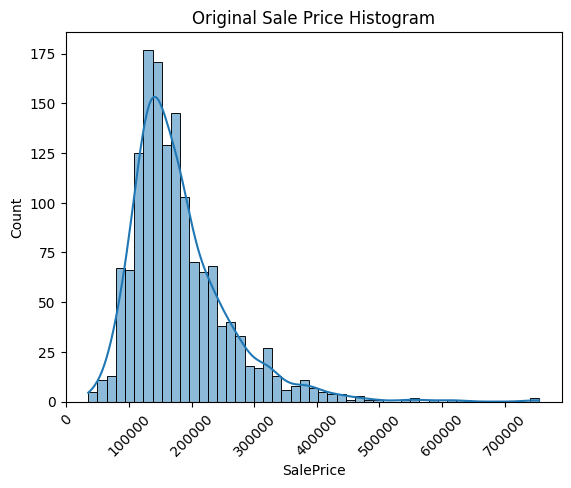

In [12]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sb.histplot(house_df['SalePrice'], kde=True)
plt.show()

> 10000~20000 에 집중되어 분포되어있다. 따라서 정규분포를 띄게 하기 위해 `로그변환`이 필요하다.

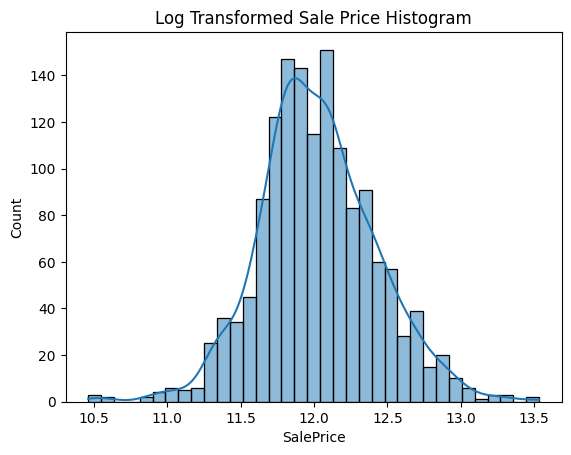

In [13]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sb.histplot(log_SalePrice, kde=True)
plt.show()

> 로그변환 이후 정규분포 형태로 결과값이 분포함을 확인

### 2. 전처리
- 종속변수 SalePrice : 로그변환
- 독립변수 int/float형 : null값 처리
- 독립변수 object형 : get_dummies 처리

In [15]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [19]:
num_cols = house_df.select_dtypes(np.number).columns
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [18]:
# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df[num_cols].fillna(house_df[num_cols].mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type:
 LotFrontage     float64
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
dtype: object


> 왜 float형은 평균값으로 fillna가 안되지..? 고로 다시 채워주기로 함.

In [26]:
house_df['LotFrontage'].fillna(house_df['LotFrontage'].mean(), inplace=True)
house_df['MasVnrArea'].fillna(house_df['MasVnrArea'].mean(), inplace=True)
house_df['GarageYrBlt'].fillna(house_df['GarageYrBlt'].mean(), inplace=True)

In [28]:
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type:
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


> object형만 null값이 있다. -> object형은 원핫인코딩으로 변환!

In [29]:
print('get_dummies() 수행 전 데이터 shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 270)
## Null 피처의 Type:
 Series([], dtype: object)


### 3. 모델링 및 평가

#### 평가 함수 정의

In [31]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

#### 모델링

##### **1. train_test_split 한 뒤 모델링 및 평가**

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg= LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[0.13183184688250651, 0.12740582836266182, 0.17628250556471403]

##### 피처별 회귀 계수 확인해보기

In [33]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위10개, - 하위 10개의 회귀계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    
    return coef_high, coef_low

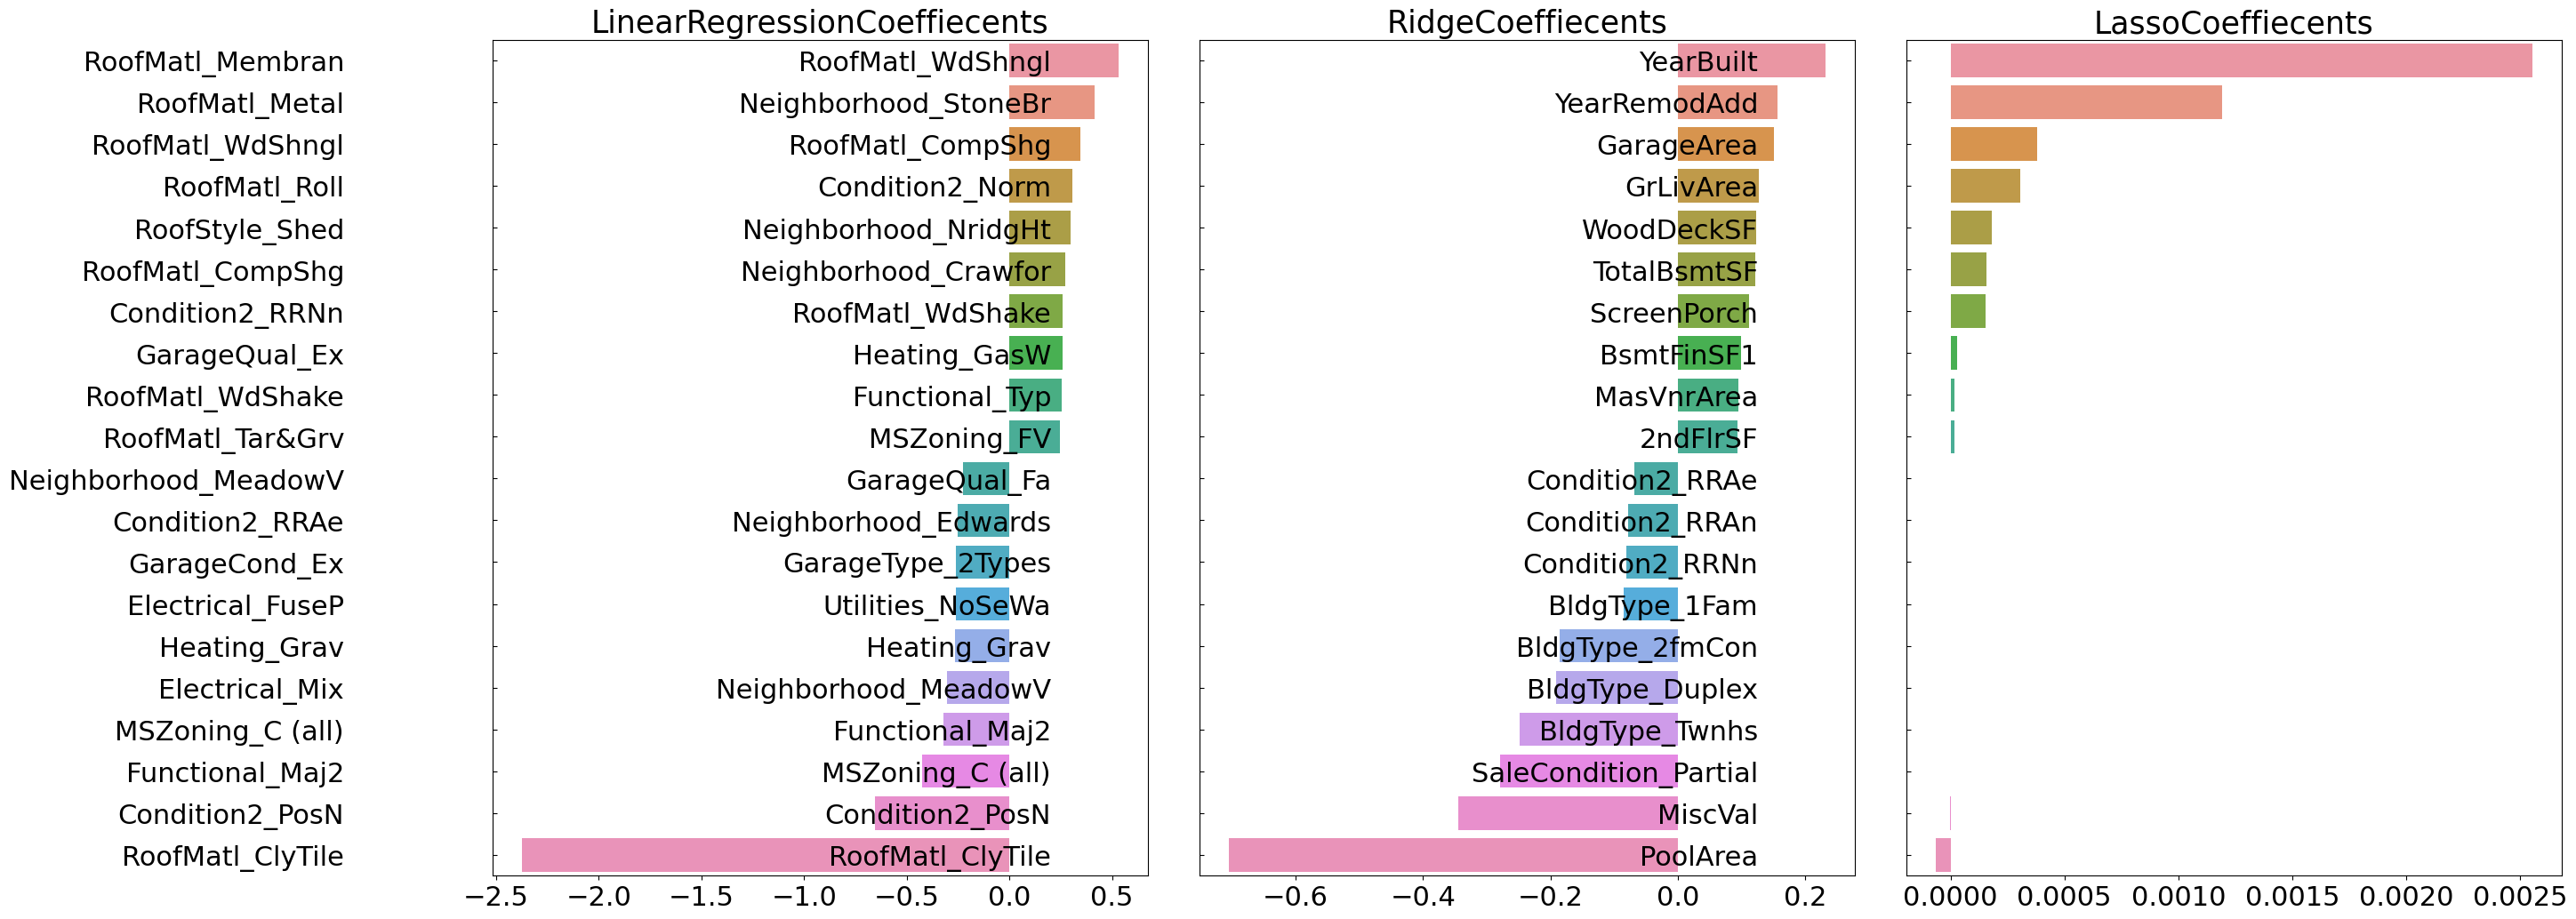

In [35]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()

    # 입력 인자로 받은 list객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ + 'Coeffiecents', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sb.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

> LinearRegression과 Ridge의 경우 회귀계수가 유사한 형태로 분포되어 있다. 하지만 Lasso는 전체적으로 회귀 계수 값이 매우 작고, 그와중에 YearBuilt가 가장 크고 다른 피처의 회귀계수는 너무 작다. 

> 학습 데이터의 데이터 분할 문제가 있을 수 있으므로, 학습과 테스트 데이터 세트를 train_test_split으로 나누지 않고 전체 데이터세트는 X_features와 y_target을 5개 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정해보겠다. 이를 위해 cross_val_score를 이용

##### **2. train_test_split없이 전체 데이터에 대해 CV하여 모델링**

In [36]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score()수행. 모델별 CV RMSE 값 평균 RMSE 출력.
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)              


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.167 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


> train_test_split없이 전체 X_features, y_target을 cv=5로 학습한 결과, 여전히 Lasso모델은 Linear, Ridge보다 성능이 떨어진다. 

> Ridge, Lasso에 alpha 파라미터에 변화를 주면서 최적값 도출해봐야겠다.

##### **3. Ridge, Lasso 모델은 alpha 값 변화주면서 최적값 도출**

In [ ]:
from sklearn.model_selection import GridSearchCV